In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('resnet_dataset')

room_types = os.listdir('resnet_dataset')

In [2]:
rooms = []

for item in room_types:
 all_rooms = os.listdir('resnet_dataset' + '/' +item)

 for room in all_rooms:
    rooms.append((item, 'resnet_dataset' + '/' +item + '/' + room))

In [3]:
rooms_df = pd.DataFrame(data=rooms, columns=['room type', 'image'])

In [4]:
import cv2
path = 'resnet_dataset/'


im_size = 64

images = []
labels = []

for i in room_types:
    data_path = path + str(i) 
    filenames = [i for i in os.listdir(data_path) ]

    for f in filenames:
        img = cv2.imread(data_path + '/' + f)  
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [5]:
images = np.array(images)

In [6]:
images = images.astype('float32') / 255.0

In [7]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=rooms_df['room type'].values
#print(y[:5])

# for y
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
#print (y)

y=y.reshape(-1,1)
onehotencoder = OneHotEncoder(sparse_output=False)  #Converted  scalar output into vector output where the correct class will be 1 and other will be 0
Y= onehotencoder.fit_transform(y)
Y.shape  #(393, 3)

(103, 3)

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

In [9]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [33]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import GlobalAveragePooling2D
def identity_block(X, f, filters, stage, block):
    conv_base = f'res{stage}{block}_branch'
    bn_base   = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # first component
    X = Conv2D(F1, (1,1), strides=1, padding='valid',
               kernel_initializer=HeNormal(),
               name=conv_base+'2a')(X)
    X = BatchNormalization(name=bn_base+'2a')(X)
    X = Activation('relu')(X)

    # second component
    X = Conv2D(F2, (f,f), strides=1, padding='same',
               kernel_initializer=HeNormal(),
               name=conv_base+'2b')(X)
    X = BatchNormalization(name=bn_base+'2b')(X)
    X = Activation('relu')(X)

    # third component
    X = Conv2D(F3, (1,1), strides=1, padding='valid',
               kernel_initializer=HeNormal(),
               name=conv_base+'2c')(X)
    X = BatchNormalization(name=bn_base+'2c')(X)
    # no activation here

    # add & relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [34]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_base = f'res{stage}{block}_branch'
    bn_base   = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # main path
    X = Conv2D(F1, (1,1), strides=s, padding='valid',
               kernel_initializer=HeNormal(),
               name=conv_base+'2a')(X)
    X = BatchNormalization(name=bn_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f,f), strides=1, padding='same',
               kernel_initializer=HeNormal(),
               name=conv_base+'2b')(X)
    X = BatchNormalization(name=bn_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1), strides=1, padding='valid',
               kernel_initializer=HeNormal(),
               name=conv_base+'2c')(X)
    X = BatchNormalization(name=bn_base+'2c')(X)
    # no activation here

    # shortcut path (projection)
    X_shortcut = Conv2D(F3, (1,1), strides=s, padding='valid',
                        kernel_initializer=HeNormal(),
                        name=conv_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_base+'1')(X_shortcut)

    # add & relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [35]:

def ResNet50(input_shape=(64,64,3), classes=3):
    """Implementation of the ResNet50 architecture:
    CONV2D → BATCHNORM → RELU → MAXPOOL
    → CONVBLOCK → IDBLOCK ×2
    → CONVBLOCK → IDBLOCK ×3
    → CONVBLOCK → IDBLOCK ×5
    → CONVBLOCK → IDBLOCK ×2
    → AVGPOOL → TOPLAYER"""
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)

    # Stage 1
    X = Conv2D(64, (7,7), strides=(2,2), name='conv1',
               kernel_initializer=HeNormal())(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2), padding='valid')(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64,64,256], stage=2, block='b')
    X = identity_block(X, 3, [64,64,256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    for blk in ['b','c','d','e','f']:
        X = identity_block(X, 3, [256,256,1024], stage=4, block=blk)

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    # Replace spatial pooling + Flatten with global average pool
    X = GlobalAveragePooling2D(name='avg_pool')(X)

    X = Dense(classes, activation='softmax',
              kernel_initializer=HeNormal(),
              name='fc' + str(classes))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model

In [36]:
model = ResNet50((64,64,3),classes=3)

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_7              │ (None, 70, 70, 3)         │               0 │ input_layer_7[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 32, 32, 64)        │           9,472 │ zero_padding2d_7[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1 (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_329 (Activation)   │ (None, 32, 32, 64)        │               0 │ bn_conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 15, 15, 64)        │               0 │ activation_329[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a (Conv2D)       │ (None, 15, 15, 64)        │           4,160 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2a[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_330 (Activation)   │ (None, 15, 15, 64)        │               0 │ bn2a_branch2a[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b (Conv2D)       │ (None, 15, 15, 64)        │          36,928 │ activation_330[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2b                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2b[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_331 (Activation)   │ (None, 15, 15, 64)        │               0 │ bn2a_branch2b[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2c (Conv2D)       │ (None, 15, 15, 256)       │          16,640 │ activation_331[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch1 (Conv2D)        │ (None, 15, 15, 256)       │          16,640 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2c                 │ (None, 15, 15, 256)       │           1,024 │ res2a_branch2c[0][0]       │
│ (BatchNormalization)          │                           │               

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [39]:
model.fit(train_x, train_y, epochs = 6, batch_size = 32) 

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.3206 - loss: 2.7137
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.4638 - loss: 1.7197
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.5262 - loss: 2.1039
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.4857 - loss: 2.0122
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.5448 - loss: 1.1395
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.4327 - loss: 1.3027


In [40]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 880.2294
Loss = 880.2294311523438
Test Accuracy = 0.3333333432674408


Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[1. 0. 0.]]


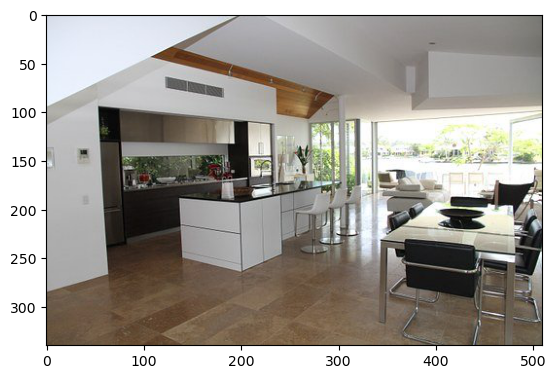

In [41]:
from matplotlib.pyplot import imread
img_path = 'apartment-185779__340.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))